In [1]:
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import rotate
from sklearn.preprocessing import MinMaxScaler
import random

## 1. Configuration et Chargement des Données


In [4]:
data_path = '/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar'
extract_to = '/kaggle/working/'

In [5]:
# First extract the data
def extract_brats_data(tar_path, extract_dir):
    """Extract BraTS tar file with error handling"""
    try:
        print(f"Extracting {tar_path}...")
        with tarfile.open(tar_path, 'r') as tar:
            tar.extractall(extract_dir)
        print("Extraction complete.")
        return True
    except Exception as e:
        print(f"Error extracting: {e}")
        return False

# Extract the data
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

extract_success = extract_brats_data(data_path, extract_to)

Extracting /kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar...
Extraction complete.


## 2. Chargement et Préparation des Données


In [6]:
def load_brats_samples(extract_dir, max_samples=5):
    """Load sample data from extracted directory"""
    subjects = sorted([d for d in os.listdir(extract_dir) if d.startswith('BraTS')])
    if not subjects:
        print("No subjects found!")
        return None
    
    subjects = subjects[:max_samples]
    brats_data = []
    
    for subject in subjects:
        try:
            base_path = os.path.join(extract_dir, subject)
            modalities = {
                'flair': nib.load(os.path.join(base_path, f"{subject}_flair.nii.gz")).get_fdata(),
                't1': nib.load(os.path.join(base_path, f"{subject}_t1.nii.gz")).get_fdata(),
                't1ce': nib.load(os.path.join(base_path, f"{subject}_t1ce.nii.gz")).get_fdata(),
                't2': nib.load(os.path.join(base_path, f"{subject}_t2.nii.gz")).get_fdata(),
                'seg': nib.load(os.path.join(base_path, f"{subject}_seg.nii.gz")).get_fdata()
            }
            brats_data.append(modalities)
        except Exception as e:
            print(f"Error loading {subject}: {e}")
    
    return brats_data if brats_data else None

# Now load the data
brats_data = load_brats_samples(extract_to, max_samples=5)

# Verify loading
if brats_data:
    print(f"Successfully loaded {len(brats_data)} subjects")
    print(f"Shapes: {[v.shape for v in brats_data[0].values()]}")
else:
    print("Failed to load data")

Successfully loaded 5 subjects
Shapes: [(240, 240, 155), (240, 240, 155), (240, 240, 155), (240, 240, 155), (240, 240, 155)]


## 3. Visualisation


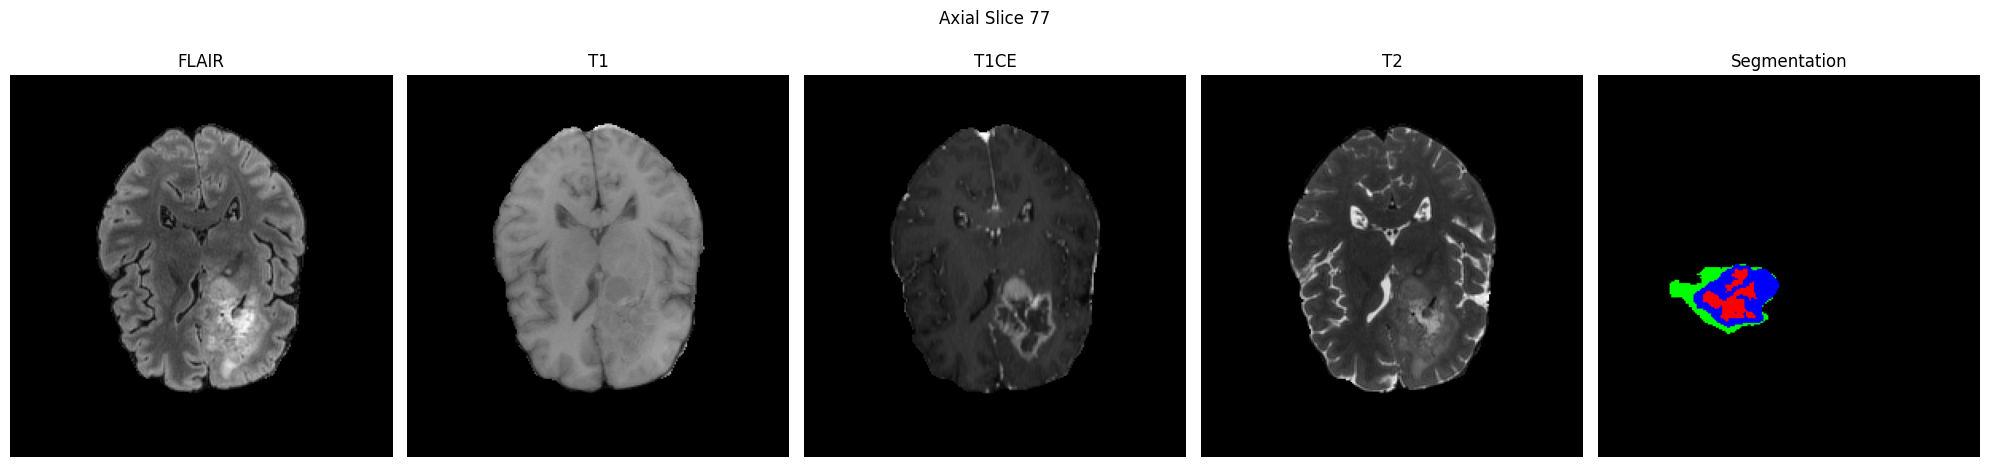

In [7]:
def plot_brats_subject(subject, slice_idx=None):
    """Plot all modalities for one subject"""
    modalities = ['flair', 't1', 't1ce', 't2', 'seg']
    titles = ['FLAIR', 'T1', 'T1CE', 'T2', 'Segmentation']
    
    if slice_idx is None:
        slice_idx = subject['flair'].shape[2] // 2
    
    plt.figure(figsize=(20, 5))
    
    for i, (mod, title) in enumerate(zip(modalities, titles)):
        plt.subplot(1, 5, i+1)
        img = subject[mod][:, :, slice_idx]
        
        if mod == 'seg':
            # Color coding for segmentation
            rgb = np.zeros((*img.shape, 3))
            rgb[img == 1] = [1, 0, 0]  # Red
            rgb[img == 2] = [0, 1, 0]  # Green
            rgb[img == 4] = [0, 0, 1]  # Blue
            plt.imshow(rgb)
        else:
            plt.imshow(img.T, cmap='gray', origin='lower')
        
        plt.title(title)
        plt.axis('off')
    
    plt.suptitle(f"Axial Slice {slice_idx}")
    plt.tight_layout()
    plt.show()

# Visualize first subject
if brats_data:
    plot_brats_subject(brats_data[0])


## 4. Augmentation et Classe Dataset


In [8]:
class MedicalTransform:
    """Augmentation transformations for medical images"""
    def __init__(self):
        self.rng = np.random.RandomState(42)
    
    def __call__(self, img):
        try:
            img = img.copy().astype(np.float32)
            
            # Random rotation
            if self.rng.rand() > 0.5:
                angle = self.rng.uniform(-15, 15)
                img = rotate(img, angle, axes=(1, 0), reshape=False)
            
            # Random flips
            if self.rng.rand() > 0.5:
                img = np.flip(img, axis=0)  # Vertical flip
            if self.rng.rand() > 0.5:
                img = np.flip(img, axis=1)  # Horizontal flip
            
            # Intensity adjustment
            if self.rng.rand() > 0.5:
                img = img * self.rng.uniform(0.8, 1.2)
            
            return img
        except Exception as e:
            print(f"Augmentation error: {e}")
            return img

class BRATSDataset(Dataset):
    def __init__(self, data, transform=None, modalities=['flair', 't1ce', 'seg']):
        self.data = data
        self.transform = transform or MedicalTransform()
        self.modalities = [m for m in modalities if m in data[0]]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        try:
            subject = self.data[idx]
            
            # Load and transform images
            images = []
            for mod in self.modalities:
                if mod != 'seg':
                    img = subject[mod]
                    if self.transform:
                        img = self.transform(img)
                    images.append(img)
                else:
                    seg = subject[mod]
            
            # Convert to tensors
            images = torch.from_numpy(np.stack(images)).float()
            seg = torch.from_numpy(seg).float()
            
            return images, seg
        
        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            # Return zero tensors of correct shape
            return torch.zeros(len(self.modalities)-1, 240, 240, 155), torch.zeros(240, 240, 155)


## 5. Création et Test du DataLoader



Batch 0:
Images shape: torch.Size([2, 2, 240, 240, 155])
Segmentation shape: torch.Size([2, 240, 240, 155])


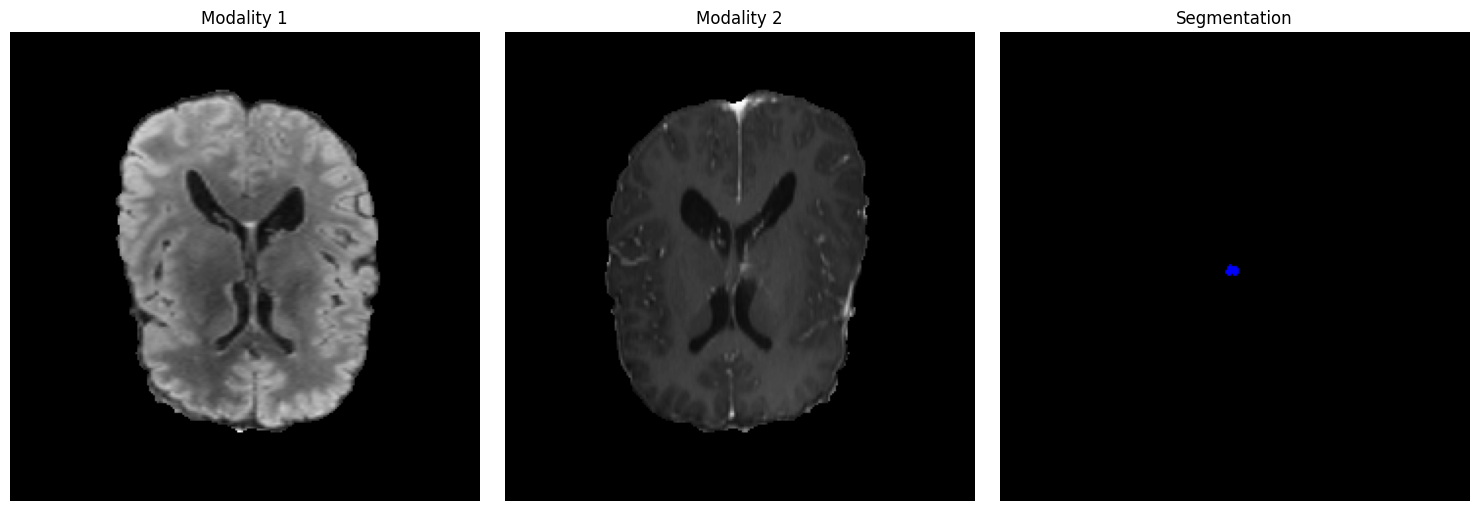


Batch 1:
Images shape: torch.Size([2, 2, 240, 240, 155])
Segmentation shape: torch.Size([2, 240, 240, 155])


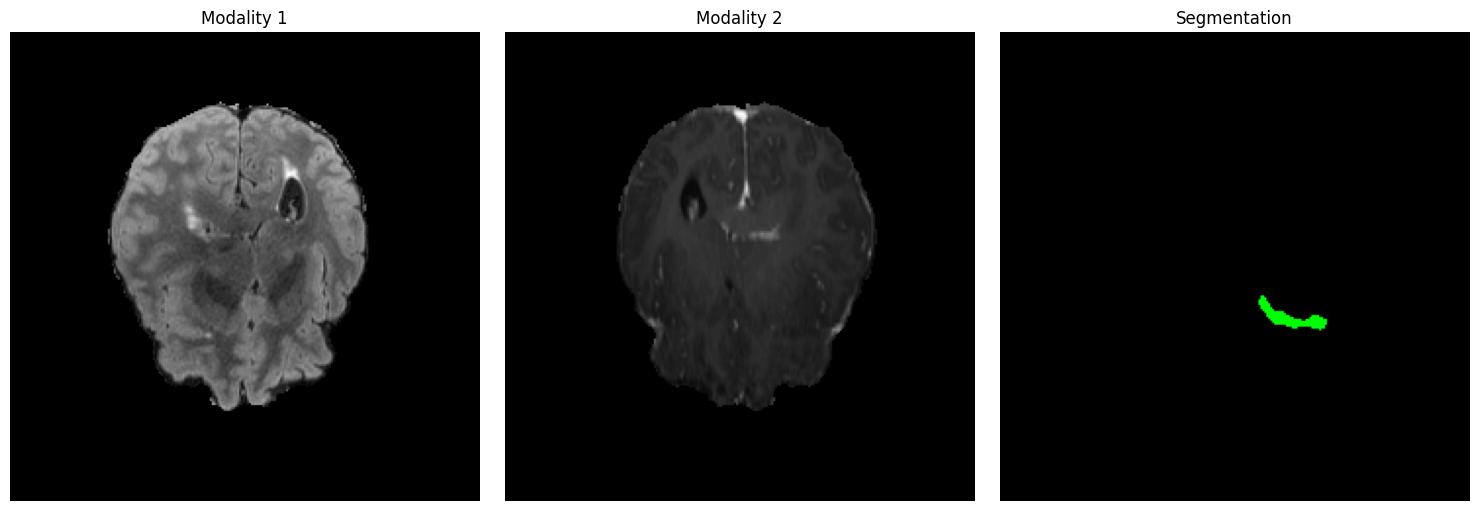

In [9]:
def brats_collate(batch):
    """Custom collate function to handle invalid samples"""
    batch = [b for b in batch if b is not None]
    if not batch:
        # Return empty batch if all samples failed
        return torch.zeros(0, len(batch[0][0]), 240, 240, 155), torch.zeros(0, 240, 240, 155)
    return torch.utils.data.dataloader.default_collate(batch)

if brats_data:
    try:
        # Create dataset with 3 modalities
        dataset = BRATSDataset(brats_data)
        
        # Create dataloader
        dataloader = DataLoader(
            dataset,
            batch_size=2,
            shuffle=True,
            num_workers=2,
            collate_fn=brats_collate
        )
        
        # Test the dataloader
        for batch_idx, (images, segs) in enumerate(dataloader):
            print(f"\nBatch {batch_idx}:")
            print(f"Images shape: {images.shape}")
            print(f"Segmentation shape: {segs.shape}")
            
            # Visualize first sample in batch
            sample_img = images[0]  # First sample
            sample_seg = segs[0]    # First segmentation
            
            # Show middle slice
            slice_idx = sample_img.shape[-1] // 2
            
            plt.figure(figsize=(15, 5))
            
            # Show each modality
            for i in range(sample_img.shape[0]):
                plt.subplot(1, sample_img.shape[0]+1, i+1)
                plt.imshow(sample_img[i, :, :, slice_idx].numpy().T, cmap='gray')
                plt.title(f"Modality {i+1}")
                plt.axis('off')
            
            # Show segmentation
            plt.subplot(1, sample_img.shape[0]+1, sample_img.shape[0]+1)
            seg_slice = sample_seg[:, :, slice_idx].numpy()
            rgb = np.zeros((*seg_slice.shape, 3))
            rgb[seg_slice == 1] = [1, 0, 0]
            rgb[seg_slice == 2] = [0, 1, 0]
            rgb[seg_slice == 4] = [0, 0, 1]
            plt.imshow(rgb)
            plt.title("Segmentation")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            if batch_idx >= 1:  # Only show 2 batches
                break
                
    except Exception as e:
        print(f"Error creating DataLoader: {e}")
else:
    print("Cannot create DataLoader - no data available")
